<a href="https://colab.research.google.com/github/ricoprediansyah/CV-RESNET50_PPE_SEFTY-5-Evaluation-/blob/main/RESNET_50_PPE_SEFTY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA EKPLORASI

In [1]:
#import library awal

import tensorflow as tf
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
csv_path = '/content/drive/MyDrive/PPE/train/_annotations.csv'
train_df = pd.read_csv(csv_path)

csv_path = '/content/drive/MyDrive/PPE/valid/_annotations.csv'
valid_df = pd.read_csv(csv_path)

csv_path = '/content/drive/MyDrive/PPE/test/_annotations.csv'
test_df = pd.read_csv(csv_path)

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                            filename  width  height class  \
0   r167_jpg.rf.f509fd025f3a56fac9269d84f7475e87.jpg    640     640  vest   
1   r167_jpg.rf.f509fd025f3a56fac9269d84f7475e87.jpg    640     640  vest   
2  TsirinOne0032_jpg.rf.f12ba2251a796f418148c4922...    640     640  vest   
3  TsirinOne0032_jpg.rf.f12ba2251a796f418148c4922...    640     640  vest   
4  TsirinOne0032_jpg.rf.f12ba2251a796f418148c4922...    640     640  vest   

   xmin  ymin  xmax  ymax  
0    52   138   271   492  
1   374   146   578   499  
2   317   151   640   640  
3    39   279   102   533  
4   153   201   344   640  
                                            filename  width  height   class  \
0  image_197_jpg.rf.ccb7436fddabb8aa8aaea5799e158...    640     640  helmet   
1  image_197_jpg.rf.ccb7436fddabb8aa8aaea5799e158...    640     640    vest   
2  image_197_jpg.rf.ccb7436fddabb8aa8aaea5799e158...    640     640   boots   
3  image_197_jpg.rf.ccb7436fddabb8aa8aaea5799e158... 

In [4]:
def load_images_and_labels(df, image_folder):
    images = []
    labels = []

    for index, row in df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        img = cv2.imread(img_path)

        if img is not None:
            # Ambil bounding box dari CSV
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            class_id = row['class']

            # Crop dan resize gambar sesuai bounding box
            cropped_img = img[ymin:ymax, xmin:xmax]
            resized_img = cv2.resize(cropped_img, (128, 128))

            images.append(resized_img)
            labels.append(class_id)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [5]:
# Path ke folder yang berisi gambar
train_images_path = '/content/drive/MyDrive/PPE/train'
valid_images_path = '/content/drive/MyDrive/PPE/valid'
test_images_path = '/content/drive/MyDrive/PPE/test'

train_images, train_labels = load_images_and_labels(train_df, train_images_path)
valid_images, valid_labels = load_images_and_labels(valid_df, valid_images_path)
test_images, test_labels = load_images_and_labels(test_df, test_images_path)

In [6]:
# Normalize images
train_images = train_images / 255.0
valid_images = valid_images / 255.0
test_images = test_images / 255.0

In [7]:
# Print jumlah gambar yang terbaca
print(f'Number of training images: {len(train_images)}')
print(f'Number of validation images: {len(valid_images)}')
print(f'Number of test images: {len(test_images)}')

# Print jumlah label yang terbaca
print(f'Number of training labels: {len(train_labels)}')
print(f'Number of validation labels: {len(valid_labels)}')
print(f'Number of test labels: {len(test_labels)}')

Number of training images: 6590
Number of validation images: 1462
Number of test images: 462
Number of training labels: 6590
Number of validation labels: 1462
Number of test labels: 462


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [46]:
# Pastikan Anda memuat dan menyusun `class_names` sesuai dengan label yang benar
# Menentukan class_names secara manual untuk memastikan urutannya benar
class_names = ['vest', 'boots', 'gloves', 'glasses', 'helmet']

# Encode label teks menjadi angka
label_encoder = LabelEncoder()
label_encoder.fit(class_names)  # Pastikan label encoder mendapatkan semua kelas dengan benar

train_labels_encoded = label_encoder.transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# One-hot encoding pada label
train_labels_one_hot = to_categorical(train_labels_encoded)
valid_labels_one_hot = to_categorical(valid_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

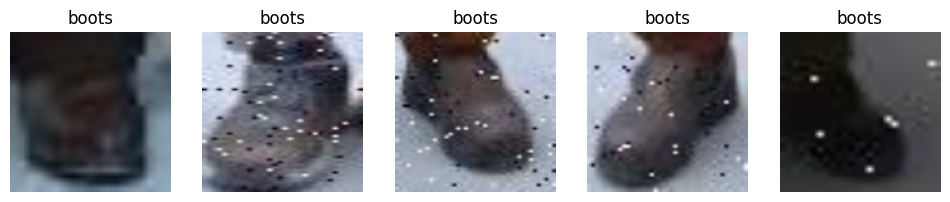

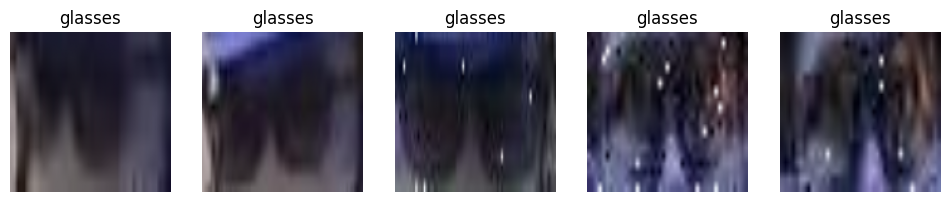

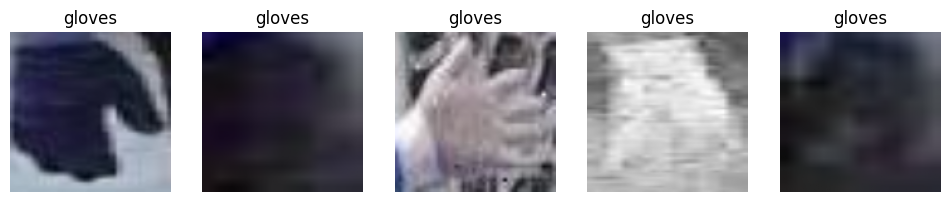

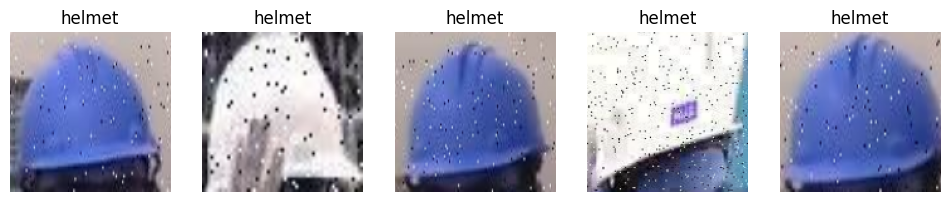

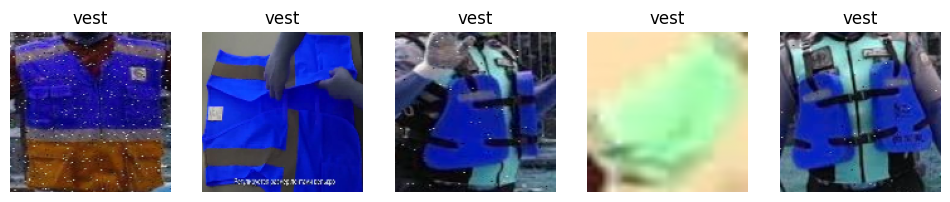

In [10]:
# Tampilkan beberapa gambar dan label
def plot_sample_images(images, one_hot_labels, label_encoder, num_samples=5):
    num_classes = one_hot_labels.shape[1]  # Jumlah kelas
    for i in range(num_classes):
        class_indices = np.where(np.argmax(one_hot_labels, axis=1) == i)[0]  # Indeks gambar untuk kelas ini
        if len(class_indices) > num_samples:
            selected_indices = np.random.choice(class_indices, num_samples, replace=False)  # Pilih beberapa gambar secara acak
        else:
            selected_indices = class_indices

        plt.figure(figsize=(12, 3))
        for j, idx in enumerate(selected_indices):
            plt.subplot(1, num_samples, j+1)
            plt.imshow(images[idx])
            plt.title(label_encoder.classes_[i])
            plt.axis('off')
        plt.show()

# Menampilkan contoh gambar
plot_sample_images(train_images, train_labels_one_hot, label_encoder)

In [11]:
# Data augmentation
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True,
    fill_mode="nearest")

##MODELLING

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [13]:
# Parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
height = 128
width = 128
depth = 3

In [14]:
# Model definition
def build_resnet50_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [15]:
# Number of classes
num_classes = len(label_encoder.classes_)

In [16]:
# Build model
model = build_resnet50_model(num_classes)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# Cek model resnet50
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,902,021 (94.99 MB)

 Trainable params: 1,314,309 (5.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [19]:
# Compile model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [20]:
# Train the model
history = model.fit(
    aug.flow(train_images, train_labels_one_hot, batch_size=BS),
    validation_data=(valid_images, valid_labels_one_hot),
    steps_per_epoch=len(train_images) // BS,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


205/205 ━━━━━━━━━━━━━━━━━━━━ 62s 220ms/step - accuracy: 0.2857 - loss: 1.5728 - val_accuracy: 0.4207 - val_loss: 1.3601
Epoch 2/25
  1/205 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4375 - loss: 1.3708

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4375 - loss: 1.3708 - val_accuracy: 0.4275 - val_loss: 1.3638
Epoch 3/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.3686 - loss: 1.4470 - val_accuracy: 0.4248 - val_loss: 1.2574
Epoch 4/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4375 - loss: 1.3746 - val_accuracy: 0.4254 - val_loss: 1.2561
Epoch 5/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - accuracy: 0.4119 - loss: 1.3613 - val_accuracy: 0.4446 - val_loss: 1.1937
Epoch 6/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5000 - loss: 1.2351 - val_accuracy: 0.4405 - val_loss: 1.2018
Epoch 7/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.4287 - loss: 1.3147 - val_accuracy: 0.4754 - val_loss: 1.1772
Epoch 8/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5000 - loss: 1.2038 - val_accuracy: 0.4480 - val_loss: 1.1748
Epoch 9/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.4482 - loss: 1.2730 - val_accuracy:

##EVALUASI

In [21]:
# 1. Evaluasi Akurasi dan Loss
print("[INFO] Calculating model accuracy...")
scores = model.evaluate(test_images, test_labels_one_hot)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

[INFO] Calculating model accuracy...
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.6829 - loss: 0.9059
Test Accuracy: 67.97%


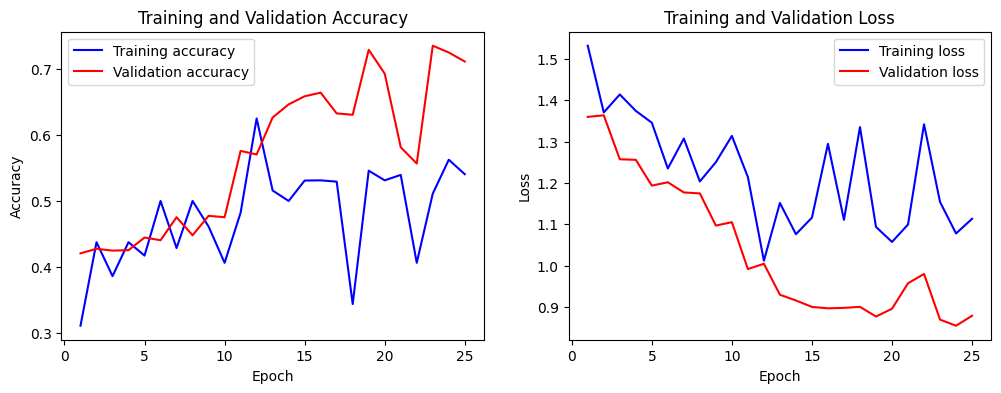

In [22]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [25]:
from sklearn.metrics import classification_report

# Nama kelas
class_names = ['vest', 'boots', 'gloves', 'glasses', 'helmet']

# Prediksi pada data uji
predictions = model.predict(test_images)
predictions_categorical = np.argmax(predictions, axis=1)

# Jika test_labels_one_hot adalah one-hot encoded
test_labels_categorical = np.argmax(test_labels_one_hot, axis=1)

# Hitung dan tampilkan classification report
report = classification_report(test_labels_categorical, predictions_categorical, target_names=class_names)
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

        vest       0.55      0.87      0.67       122
       boots       0.72      0.81      0.76        52
      gloves       0.66      0.35      0.46       119
     glasses       0.83      0.69      0.76        72
      helmet       0.85      0.76      0.80        97

    accuracy                           0.68       462
   macro avg       0.72      0.70      0.69       462
weighted avg       0.70      0.68      0.67       462



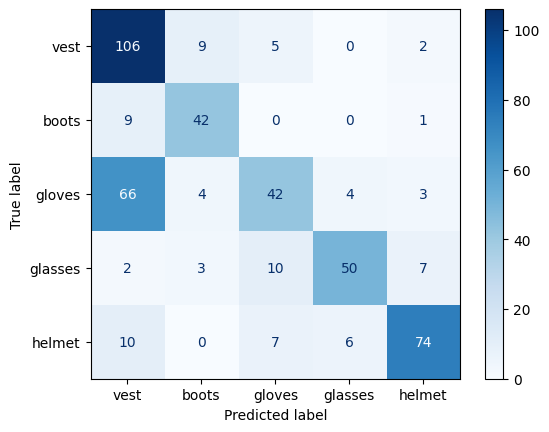

In [26]:
#3.evaluasi confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hitung confusion matrix
cm = confusion_matrix(test_labels_categorical, predictions_categorical)

# Visualisasikan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [27]:
#4. Evalusi Matthews Correlation Coefficien

from sklearn.metrics import matthews_corrcoef

# Hitung MCC
mcc = matthews_corrcoef(test_labels_categorical, predictions_categorical)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.6048


In [28]:
# 5. Evaluasi Log Loss
from sklearn.metrics import log_loss

# Hitung log loss
loss = log_loss(test_labels_one_hot, predictions)
print(f"Log Loss: {loss:.4f}")


Log Loss: 0.9147


In [ ]:
# # Encode label teks menjadi angka
# label_encoder = LabelEncoder()
# train_labels_encoded = label_encoder.fit_transform(train_labels)
# valid_labels_encoded = label_encoder.transform(valid_labels)
# test_labels_encoded = label_encoder.transform(test_labels)

# # Cek label encoder
# print("Label Encoder classes:", label_encoder.classes_)

# def plot_sample_images(images, one_hot_labels, label_encoder, num_samples=5):
#     num_classes = one_hot_labels.shape[1]
#     for i in range(num_classes):
#         class_indices = np.where(np.argmax(one_hot_labels, axis=1) == i)[0]
#         if len(class_indices) > num_samples:
#             selected_indices = np.random.choice(class_indices, num_samples, replace=False)
#         else:
#             selected_indices = class_indices

#         plt.figure(figsize=(12, 3))
#         for j, idx in enumerate(selected_indices):
#             plt.subplot(1, num_samples, j + 1)
#             plt.imshow(images[idx])
#             plt.title(label_encoder.classes_[i])
#             plt.axis('off')
#         plt.show()

##TEST PREDIKSI

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


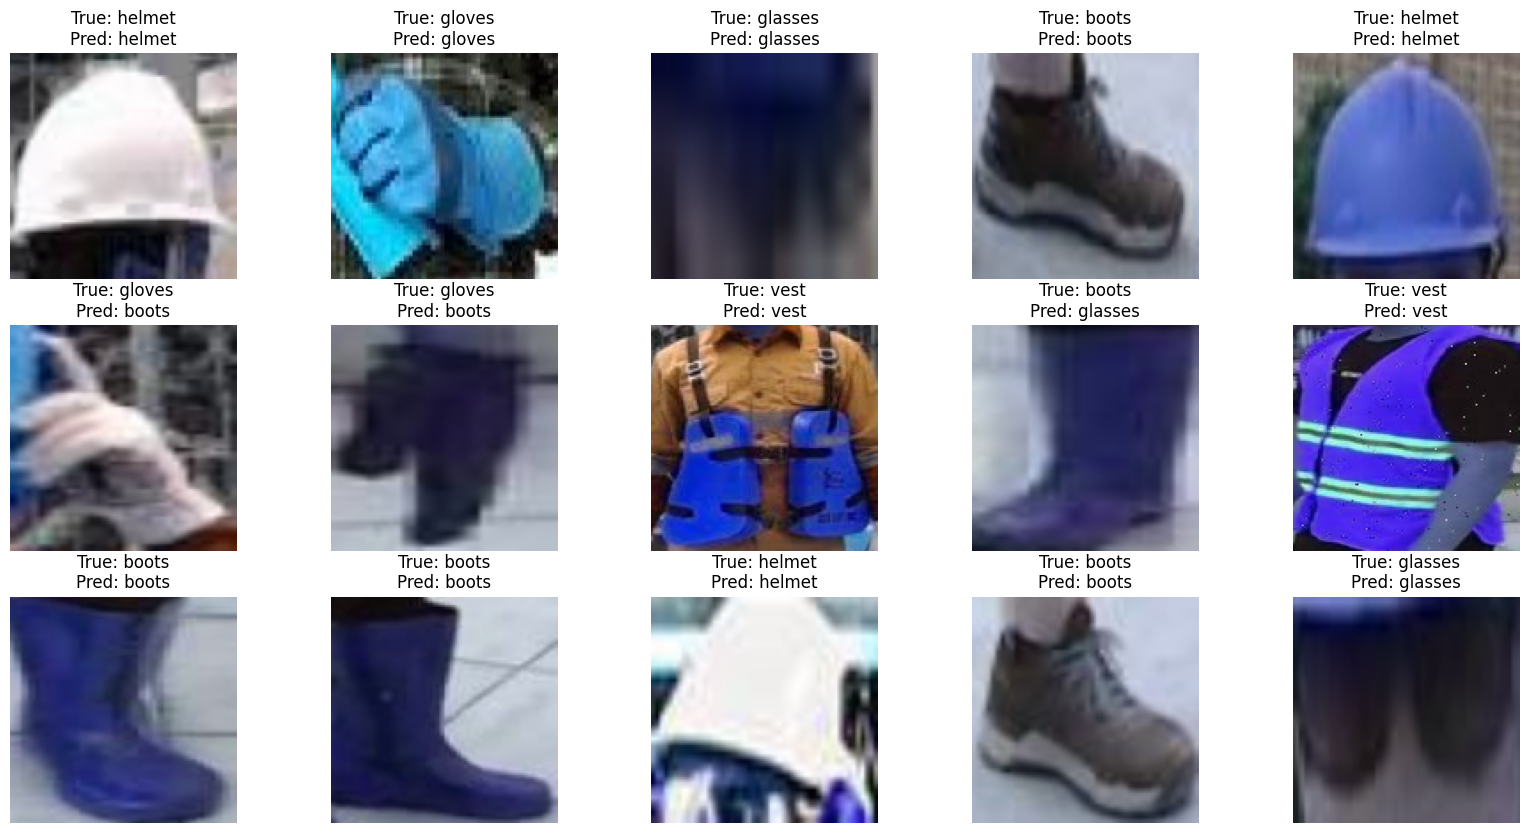

In [64]:
# Ambil beberapa gambar acak dari data uji
sample_indices = np.random.choice(len(test_images), 15, replace=False)

# Lihat beberapa prediksi
predictions = model.predict(test_images[sample_indices])
predictions_categorical = np.argmax(predictions, axis=1)
true_labels = test_labels_categorical[sample_indices]

# Menampilkan gambar, label sebenarnya, dan prediksi
plt.figure(figsize=(20, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 5, i + 1)  # 3 baris, 5 kolom
    plt.imshow(test_images[idx])
    true_label_name = label_encoder.inverse_transform([true_labels[i]])[0]
    predicted_label_name = label_encoder.inverse_transform([predictions_categorical[i]])[0]
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}")
    plt.axis('off')
plt.show()
